# ML survival model on the data of cancer eye patients

In [1]:
import pandas as pd

df = pd.read_csv('eye_cancer_patients.csv')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   Patient_ID            5000 non-null   object
 1   Age                   5000 non-null   int64 
 2   Gender                5000 non-null   object
 3   Cancer_Type           5000 non-null   object
 4   Laterality            5000 non-null   object
 5   Date_of_Diagnosis     5000 non-null   object
 6   Stage_at_Diagnosis    5000 non-null   object
 7   Treatment_Type        5000 non-null   object
 8   Surgery_Status        5000 non-null   bool  
 9   Radiation_Therapy     5000 non-null   int64 
 10  Chemotherapy          5000 non-null   int64 
 11  Outcome_Status        5000 non-null   object
 12  Survival_Time_Months  5000 non-null   int64 
 13  Genetic_Markers       2503 non-null   object
 14  Family_History        5000 non-null   bool  
 15  Country               5000 non-null   

### Data cleaning

In [2]:
df_new = df
df_new['has_BRAF'] = pd.notna(df_new['Genetic_Markers'])
df_new = df_new.drop(['Patient_ID', 'Genetic_Markers', 'Date_of_Diagnosis', 'Country'], axis = 1)
df_new = pd.get_dummies(df_new, columns=['Gender', 'Cancer_Type', 'Laterality', 'Stage_at_Diagnosis', 'Treatment_Type', 'Outcome_Status'], drop_first=True)
df_new.head()

,Age,Surgery_Status,Radiation_Therapy,Chemotherapy,Survival_Time_Months,Family_History,has_BRAF,Gender_M,Gender_Other,Cancer_Type_Melanoma,Cancer_Type_Retinoblastoma,Laterality_Left,Laterality_Right,Stage_at_Diagnosis_Stage II,Stage_at_Diagnosis_Stage III,Stage_at_Diagnosis_Stage IV,Treatment_Type_Radiation,Treatment_Type_Surgery,Outcome_Status_Deceased,Outcome_Status_In Remission
0,58,False,15,3,85,True,False,False,False,False,True,True,False,False,False,True,True,False,True,False
1,15,True,69,6,10,True,False,False,True,False,True,False,True,False,True,False,False,False,False,True
2,64,False,47,6,3,False,True,True,False,False,True,False,False,False,False,True,False,True,False,True
3,33,True,36,6,40,False,False,True,False,True,False,False,True,True,False,False,True,False,False,False
4,8,False,14,14,26,True,True,False,True,False,False,True,False,False,False,False,False,False,False,True


### Preparing the model

In [3]:
from sksurv.util import Surv

# duration and event columns
y = Surv.from_dataframe(event="Outcome_Status_Deceased", 
                        time="Survival_Time_Months", 
                        data=df_new)

X = df_new.drop(columns=["Survival_Time_Months", "Outcome_Status_Deceased", "Outcome_Status_In Remission"])


In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [5]:
from sksurv.ensemble import RandomSurvivalForest

rsf = RandomSurvivalForest(
    n_estimators=100,
    min_samples_split=10,
    min_samples_leaf=15,
    max_features="sqrt",
    n_jobs=-1,
    random_state=42
)

rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=15, min_samples_split=10, n_jobs=-1,
                     random_state=42)

In [6]:
c_index = rsf.score(X_test, y_test)
print(f"Concordance index: {c_index:.3f}")

Concordance index: 0.526


In [10]:
rsf = RandomSurvivalForest(
    n_estimators=200,
    min_samples_split=5,
    min_samples_leaf=10,
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)

rsf.fit(X_train, y_train)

RandomSurvivalForest(min_samples_leaf=10, min_samples_split=5, n_estimators=200,
                     n_jobs=-1, random_state=42)

In [11]:
c_index = rsf.score(X_test, y_test)
print(f"Concordance index: {c_index:.3f}")

Concordance index: 0.532


In [15]:
X_test_sorted = X_test.sort_values(by=["Family_History", "Radiation_Therapy"])
X_test_sel = pd.concat((X_test_sorted.head(3), X_test_sorted.tail(3)))

X_test_sel

,Age,Surgery_Status,Radiation_Therapy,Chemotherapy,Family_History,has_BRAF,Gender_M,Gender_Other,Cancer_Type_Melanoma,Cancer_Type_Retinoblastoma,Laterality_Left,Laterality_Right,Stage_at_Diagnosis_Stage II,Stage_at_Diagnosis_Stage III,Stage_at_Diagnosis_Stage IV,Treatment_Type_Radiation,Treatment_Type_Surgery
1501,5,False,0,1,False,False,False,True,True,False,True,False,False,False,True,True,False
3161,43,True,0,13,False,True,False,True,True,False,False,False,False,True,False,False,False
1338,77,True,0,1,False,False,False,True,True,False,True,False,False,True,False,False,False
26,87,False,70,1,True,True,False,True,False,True,False,True,True,False,False,True,False
4707,5,False,70,14,True,True,True,False,True,False,True,False,False,True,False,True,False
1075,72,False,70,20,True,True,True,False,True,False,True,False,False,True,False,True,False


In [16]:
pd.Series(rsf.predict(X_test_sel))

0    39.906033
1    40.034906
2    45.104080
3    38.577642
4    33.514901
5    36.190963
dtype: float64

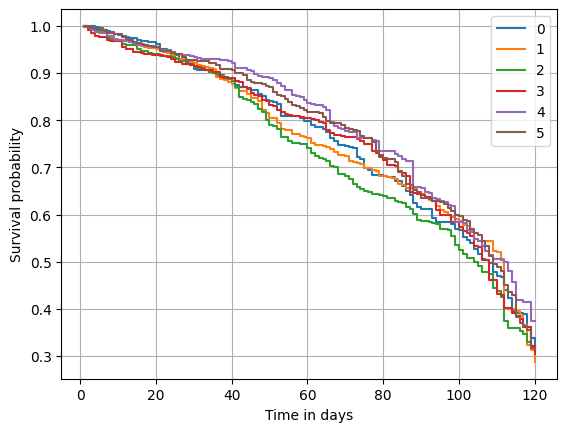

In [17]:
surv = rsf.predict_survival_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Survival probability")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

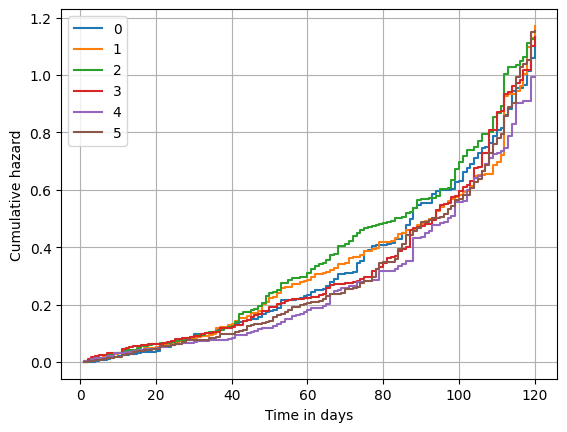

In [18]:
surv = rsf.predict_cumulative_hazard_function(X_test_sel, return_array=True)

for i, s in enumerate(surv):
    plt.step(rsf.unique_times_, s, where="post", label=str(i))
plt.ylabel("Cumulative hazard")
plt.xlabel("Time in days")
plt.legend()
plt.grid(True)

In [20]:
from sklearn.inspection import permutation_importance

result = permutation_importance(rsf, X_test, y_test, n_repeats=15, random_state=42)

In [21]:
pd.DataFrame(
    {
        k: result[k]
        for k in (
            "importances_mean",
            "importances_std",
        )
    },
    index=X_test.columns,
).sort_values(by="importances_mean", ascending=False)

,importances_mean,importances_std
Chemotherapy,0.019413,0.009013
Radiation_Therapy,0.016966,0.009692
Treatment_Type_Surgery,0.013002,0.005498
has_BRAF,0.011836,0.006265
Surgery_Status,0.011243,0.007446
Gender_M,0.009643,0.003786
Age,0.008533,0.009672
Laterality_Right,0.005957,0.004328
Family_History,0.005399,0.007098
Stage_at_Diagnosis_Stage III,0.004354,0.004615
